<a href="https://colab.research.google.com/github/Elisha-Hart/Capstone-Project-Folder_Elisha-Hart/blob/main/CT_Scan_Image_COVID_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Libraries
import numpy as np # linear algebra
import pandas as pd #(pd.read_csv)
import os
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import Model


In [48]:
!pip install keras

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import zipfile

**Creating Helper Functions**

In [ ]:
import nibabel as nib

from scipy import ndimage

def read_nifti_file(filepath):
    """Reading and loading volume"""
    # Reading the file
    scan = nib.load(filepath)
    # Getting data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Setting the wanted depth
    wanted_depth = 64
    wanted_width = 128
    wanted_height = 128
    # Getting the present depth
    present_depth = img.shape[-1]
    present_width = img.shape[0]
    present_height = img.shape[1]
    # Computing depth factor
    depth = present_depth / wanted_depth
    width = present_width / wanted_width
    height = present_height / wanted_height
    depthFactor = 1 / depth
    widthFactor = 1 / width
    heightFactor = 1 / height
    # Rotate
    image = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    image = ndimage.zoom(img, (widthFactor, heightFactor, depthFactor), order=1)
    return image

def process_scan(path):
    """Resizing and reading the volume"""
    # Read scan
    lwh = read_nifti_file(path)
    # Normalize
    lwh = normalize(volume)
    # Resize width, height, and depth
    lwh = resize_volume(volume)
    return lwh



In [ ]:
pip install nibabel

In [ ]:
# Make a directory to store the data.
os.makedirs("MosMedData")

In [40]:
# Unzip data in the newly created directory.
with zipfile.ZipFile("/content/COVID-20230807T114610Z-001.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("/content/non-COVID-20230807T114728Z-001.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

In [41]:
# Folder "Non-Covid" are CT scans having non-COVID showing on lungs,
# It shows no CT-signs of COVID.
Non_COVID_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/non-COVID", x)
    for x in os.listdir("MosMedData/non-COVID")
]
# Folder "Covid" is composed of CT scans showing COVID on lungs,

COVID_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/COVID", x)
    for x in os.listdir("MosMedData/COVID")
]

print("CT scans with Non-COVID lung: " + str(len(Non_COVID_scan_paths)))
print("CT scans with COVID lung: " + str(len(COVID_scan_paths)))

CT scans with Non-COVID lung: 1229
CT scans with COVID lung: 1252


**Data Augmentation**

In [ ]:
train_dataG = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_dataG = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_dataG  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
import random

from scipy import ndimage

@tf.function
def rotate(volume):
    """Rotating the volume by some degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        anglesR = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angleRC = random.choice(anglesR)
        # rotate volume
        volume = ndimage.rotate(volume, angleRC, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmentedVolume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmentedVolume


def train_preprocessing(volume, label):
    """Training the data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Processing the validation data by adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
data_dir = "/content/COVID-20230807T114610Z-001.zip"
img_height, img_width = 224, 224
batch_size = 64

In [ ]:
data_dir = "MosMedData/COVID"
img_height, img_width = 224, 224
batch_size = 64

**Train Model Using ResNet Layer Model-ResNet-50**

In [ ]:
baseModel = tf.keras.applications.ResNet101V2(input_shape=(224,224,3),include_top=False,weights="imagenet")
# Freezing Layers
for layer in baseModel.layers:
    layer.trainable = False

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
x = baseModel.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation = "softmax")(x)
model = Model(inputs= baseModel.input , outputs = x)


In [ ]:
ACCURACY_THRESHOLD = 0.95

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training." %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]
My_Call_Backs = myCallback()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
    plt.show()
    plot_slices(4, 10, 128, 128, image[:, :, :40])

**Creating a 3D Convolutional Neural Network**

In [ ]:
def get_model(width=128, height=128, depth=64):


    InputsK = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(InputsK)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    Results_Outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Defining the model.
    modelD = keras.Model(InputsK, Results_Outputs, name="3dcnn")
    return modelD


# Building the model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [ ]:
import cv2 as cv
img = cv.imread('/content/Covid (1).png')
assert img is not None, "file could not be read, check with os.path.exists()"
res = cv.resize(img,None,fx=2, fy=2, interpolation = cv.INTER_CUBIC)

In [ ]:
height, width = img.shape[:2]
res = cv.resize(img,(2*width, 2*height), interpolation = cv.INTER_CUBIC)

In [ ]:
res

array([[[189, 189, 189],
        [191, 191, 191],
        [195, 195, 195],
        ...,
        [190, 190, 190],
        [192, 192, 192],
        [194, 194, 194]],

       [[189, 189, 189],
        [191, 191, 191],
        [195, 195, 195],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[188, 188, 188],
        [190, 190, 190],
        [194, 194, 194],
        ...,
        [196, 196, 196],
        [191, 191, 191],
        [188, 188, 188]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

**Showing a lung that has COVID**

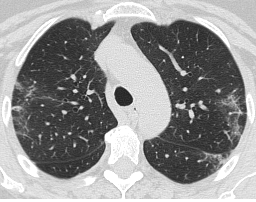

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv.waitKey(0)
cv.destroyAllWindows()

In [ ]:
import cv2 as cv
img = cv.imread('/content/Non-Covid (1).png')
assert img is not None, "file could not be read, check with os.path.exists()"
res = cv.resize(img,None,fx=2, fy=2, interpolation = cv.INTER_CUBIC)

In [ ]:
img.shape

(229, 321, 3)

In [ ]:
res.shape

(458, 642, 3)

In [ ]:
height, width = img.shape[:2]
res = cv.resize(img,(2*width, 2*height), interpolation = cv.INTER_CUBIC)

In [ ]:
res

array([[[222, 222, 222],
        [220, 220, 220],
        [216, 216, 216],
        ...,
        [209, 209, 209],
        [210, 210, 210],
        [211, 211, 211]],

       [[221, 221, 221],
        [219, 219, 219],
        [215, 215, 215],
        ...,
        [210, 210, 210],
        [211, 211, 211],
        [212, 212, 212]],

       [[219, 219, 219],
        [217, 217, 217],
        [215, 215, 215],
        ...,
        [210, 210, 210],
        [212, 212, 212],
        [212, 212, 212]],

       ...,

       [[237, 237, 237],
        [237, 237, 237],
        [238, 238, 238],
        ...,
        [231, 231, 231],
        [232, 232, 232],
        [233, 233, 233]],

       [[238, 238, 238],
        [239, 239, 239],
        [239, 239, 239],
        ...,
        [232, 232, 232],
        [233, 233, 233],
        [233, 233, 233]],

       [[239, 239, 239],
        [239, 239, 239],
        [239, 239, 239],
        ...,
        [232, 232, 232],
        [233, 233, 233],
        [233, 233, 233]]

**Showing a Non-COVID or normal lung**

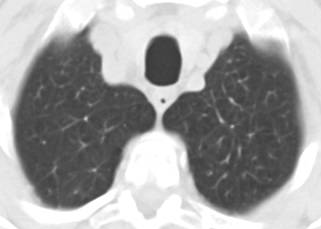

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv.waitKey(0)
cv.destroyAllWindows()

In [ ]:
img.shape

(229, 321, 3)

In [ ]:
res.shape

(458, 642, 3)

**Rotating the Non-COVID image**

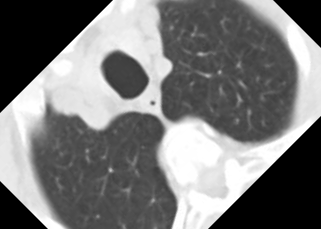

In [ ]:
img = cv.imread('/content/Non-Covid (1).png', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
rows,cols = img.shape
# cols-1 and rows-1 are the coordinate limits.
M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),45,1)
dst = cv.warpAffine(img,M,(cols,rows))
cv2_imshow(dst)



In [ ]:
# Import Libraries
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)


In [ ]:
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
input_shape=(28,28,1)
y_train=keras.utils.to_categorical(y_train) #,num_classes-)
y_test=keras.utils.to_categorical(y_test) #, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /=255

In [ ]:
x_train

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [ ]:
batch_size =64
num_classes=10
epochs=10

def build_model(optimizer):
  model=Sequential()
  model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer= optimizer, metrics=['accuracy'])


 *Viewing Accuracy*

In [ ]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='SGD',
              metrics=['accuracy'])

hist=model.fit(x_train,
               y_train,
               batch_size=batch_size, #64
               epochs=epochs, #10
               validation_data=(x_test,y_test))

Epoch 1/10
938/938 [==============================] - 52s 54ms/step - loss: 0.8525 - accuracy: 0.7441 - val_loss: 0.3180 - val_accuracy: 0.9094
Epoch 2/10
938/938 [==============================] - 49s 53ms/step - loss: 0.3888 - accuracy: 0.8820 - val_loss: 0.2344 - val_accuracy: 0.9310
Epoch 3/10
938/938 [==============================] - 50s 53ms/step - loss: 0.3173 - accuracy: 0.9042 - val_loss: 0.1951 - val_accuracy: 0.9431
Epoch 4/10
938/938 [==============================] - 51s 54ms/step - loss: 0.2734 - accuracy: 0.9171 - val_loss: 0.1686 - val_accuracy: 0.9513
Epoch 5/10
938/938 [==============================] - 48s 51ms/step - loss: 0.2490 - accuracy: 0.9247 - val_loss: 0.1521 - val_accuracy: 0.9555
Epoch 6/10
938/938 [==============================] - 53s 56ms/step - loss: 0.2248 - accuracy: 0.9333 - val_loss: 0.1350 - val_accuracy: 0.9600
Epoch 7/10
938/938 [==============================] - 50s 53ms/step - loss: 0.2112 - accuracy: 0.9388 - val_loss: 0.1276 - val_accuracy:

In [42]:
import pandas as pd
hist = pd.DataFrame(hist.history)

In [43]:
hist

,loss,accuracy,val_loss,val_accuracy
0,0.852541,0.744150,0.318018,0.9094
1,0.388790,0.882033,0.234391,0.9310
2,0.317300,0.904183,0.195081,0.9431
3,0.273416,0.917100,0.168588,0.9513
4,0.248977,0.924750,0.152116,0.9555
5,0.224772,0.933283,0.135000,0.9600
6,0.211206,0.938817,0.127573,0.9634
7,0.196638,0.940833,0.118183,0.9647
8,0.184869,0.943667,0.112354,0.9682
9,0.176229,0.947967,0.106758,0.9680


**Visualizing the Model**

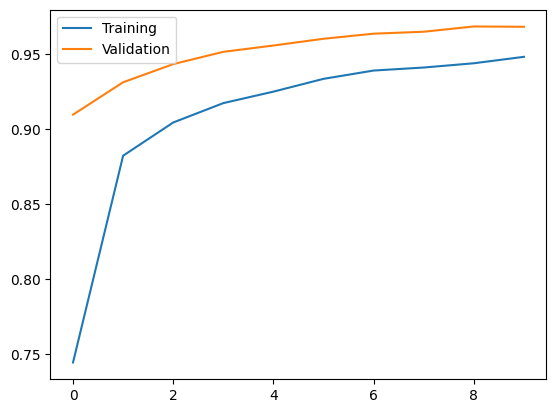

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hist['accuracy'], label='Training')
plt.plot(hist['val_accuracy'], label='Validation')
plt.legend()
plt.show()

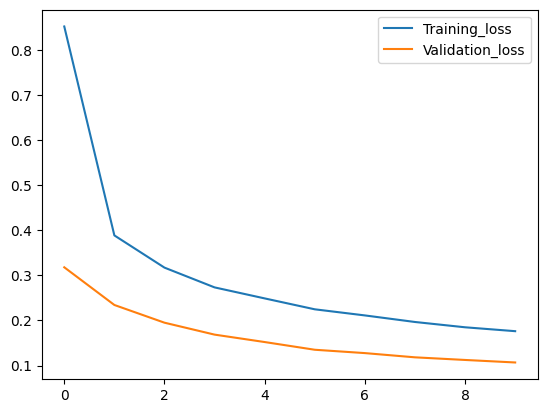

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hist['loss'], label='Training_loss')
plt.plot(hist['val_loss'], label='Validation_loss')
plt.legend()
plt.show()